In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
from pyvbmc import VBMC
import corner
from psiam_tied_no_dv_map_utils import rho_A_t_fn, up_RTs_fit_fn, down_RTs_fit_fn, psiam_tied_data_gen_wrapper

In [3]:
# read out_LED.csv as dataframe
og_df = pd.read_csv('../out_LED.csv')

In [4]:
# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

In [5]:
# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

ABL: [20 40 60]
ILD: [-16.  -8.  -4.  -2.  -1.   1.   2.   4.   8.  16.]


In [6]:
# LED off rows
df_1 = df[ df['LED_trial'] == 0 ]

# VBMC

## loglike fn

In [7]:
def compute_loglike(row, V_A, theta_A, rate_lambda, T_0, theta_E, t_A_aff, t_E_aff, t_motor, Z_E):
    timed_fix = row['timed_fix']
    intended_fix = row['intended_fix']

    is_abort =  timed_fix < intended_fix 
    
    ILD = row['ILD']
    ABL = row['ABL']
    choice = row['response_poke']
    rt = timed_fix

    
    K_max = 10

    if is_abort:
        likelihood = rho_A_t_fn(rt - t_motor - t_A_aff, V_A, theta_A)
    else:
        t_stim = intended_fix
        if choice == 3:
            likelihood = up_RTs_fit_fn([rt], V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, \
                                       t_stim, t_A_aff, t_E_aff, t_motor, K_max)[0]
        elif choice == 2:
            likelihood = down_RTs_fit_fn([rt], V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, \
                                         t_stim, t_A_aff, t_E_aff, t_motor, K_max)[0]


    if likelihood <= 0:
        likelihood = 1e-50

    
    return np.log(likelihood)    


def psiam_tied_loglike_fn(params):
    V_A, theta_A, rate_lambda, T_0, theta_E, t_A_aff, t_E_aff, t_motor, Z_E = params


    all_loglike = Parallel(n_jobs=-1)(delayed(compute_loglike)(row, V_A, theta_A, rate_lambda, T_0, theta_E, t_A_aff, t_E_aff, t_motor, Z_E)\
                                       for _, row in df_1.iterrows() if row['response_poke'] in [2,3])

    loglike = np.sum(all_loglike)
    return loglike

## Bounds

In [8]:
V_A_bounds = [0.01, 5]
theta_A_bounds = [0.01, 5]

rate_lambda_bounds = [0.01, 0.2]
T_0_bounds = [0.1*(1e-3), 0.8*(1e-3)]
theta_E_bounds = [35, 65]

t_A_aff_bounds = [0.001, 0.1]
t_E_aff_bounds = [0.001, 0.1]
t_motor_bounds = [0.001, 0.1]

Z_E_bounds = [-10, 10]

# ---
V_A_plausible_bounds = [0.1, 3]
theta_A_plausible_bounds = [0.1, 3]

rate_lambda_plausible_bounds =  [0.05, 0.09]
T_0_plausible_bounds = [0.15*(1e-3), 0.5*(1e-3)]
theta_E_plausible_bounds = [40, 55]

t_A_aff_plausible_bounds = [0.01, 0.05]
t_E_aff_plausible_bounds = [0.01, 0.05]
t_motor_plausible_bounds = [0.01, 0.05]

Z_E_plausible_bounds = [-5, 5]

## prior

In [9]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def psiam_tied_prior_fn(params):
    V_A, theta_A, rate_lambda, T_0, theta_E, t_A_aff, t_E_aff, t_motor, Z_E = params

    V_A_logpdf = trapezoidal_logpdf(V_A, V_A_bounds[0], V_A_plausible_bounds[0], V_A_plausible_bounds[1], V_A_bounds[1])
    theta_A_logpdf = trapezoidal_logpdf(theta_A, theta_A_bounds[0], theta_A_plausible_bounds[0], theta_A_plausible_bounds[1], theta_A_bounds[1])
    
    rate_lambda_logpdf = trapezoidal_logpdf(rate_lambda, rate_lambda_bounds[0], rate_lambda_plausible_bounds[0], rate_lambda_plausible_bounds[1], rate_lambda_bounds[1])
    theta_E_logpdf = trapezoidal_logpdf(theta_E, theta_E_bounds[0], theta_E_plausible_bounds[0], theta_E_plausible_bounds[1], theta_E_bounds[1])
    T_0_logpdf = trapezoidal_logpdf(T_0, T_0_bounds[0], T_0_plausible_bounds[0], T_0_plausible_bounds[1], T_0_bounds[1])
    
    t_A_aff_logpdf = trapezoidal_logpdf(t_A_aff, t_A_aff_bounds[0], t_A_aff_plausible_bounds[0], t_A_aff_plausible_bounds[1], t_A_aff_bounds[1])
    t_E_aff_logpdf = trapezoidal_logpdf(t_E_aff, t_E_aff_bounds[0], t_E_aff_plausible_bounds[0], t_E_aff_plausible_bounds[1], t_E_aff_bounds[1])
    t_motor_logpdf = trapezoidal_logpdf(t_motor, t_motor_bounds[0], t_motor_plausible_bounds[0], t_motor_plausible_bounds[1], t_motor_bounds[1])

    Z_E_logpdf = trapezoidal_logpdf(Z_E, Z_E_bounds[0], Z_E_plausible_bounds[0], Z_E_plausible_bounds[1], Z_E_bounds[1])
    
    return V_A_logpdf + theta_A_logpdf + rate_lambda_logpdf + theta_E_logpdf + T_0_logpdf + t_A_aff_logpdf + t_E_aff_logpdf + t_motor_logpdf + Z_E_logpdf


## prior + loglike

In [10]:
def psiam_tied_joint_fn(params):
    priors = psiam_tied_prior_fn(params) 
    loglike = psiam_tied_loglike_fn(params)

    joint = priors + loglike
    return joint

## run vbmc

In [10]:
lb = np.array([V_A_bounds[0], theta_A_bounds[0], rate_lambda_bounds[0], T_0_bounds[0], theta_E_bounds[0], \
               t_A_aff_bounds[0], t_E_aff_bounds[0], t_motor_bounds[0], Z_E_bounds[0]])
ub = np.array([V_A_bounds[1], theta_A_bounds[1], rate_lambda_bounds[1], T_0_bounds[1], theta_E_bounds[1], \
               t_A_aff_bounds[1], t_E_aff_bounds[1], t_motor_bounds[1], Z_E_bounds[1]])
plb = np.array([V_A_plausible_bounds[0], theta_A_plausible_bounds[0], \
                rate_lambda_plausible_bounds[0], T_0_plausible_bounds[0], theta_E_plausible_bounds[0],\
                t_A_aff_plausible_bounds[0], t_E_aff_plausible_bounds[0], t_motor_plausible_bounds[0], Z_E_plausible_bounds[0]])
pub = np.array([V_A_plausible_bounds[1], theta_A_plausible_bounds[1],\
                rate_lambda_plausible_bounds[1], T_0_plausible_bounds[1], theta_E_plausible_bounds[1],\
                t_A_aff_plausible_bounds[1], t_E_aff_plausible_bounds[1], t_motor_plausible_bounds[1], Z_E_plausible_bounds[1]])

np.random.seed(42)
V_A_0 = np.random.uniform(V_A_plausible_bounds[0], V_A_plausible_bounds[1])
theta_A_0 = np.random.uniform(theta_A_plausible_bounds[0], theta_A_plausible_bounds[1])
rate_lambda_0 = np.random.uniform(rate_lambda_plausible_bounds[0], rate_lambda_plausible_bounds[1])
T_0_0 = np.random.uniform(T_0_plausible_bounds[0], T_0_plausible_bounds[1])
theta_E_0 = np.random.uniform(theta_E_plausible_bounds[0], theta_E_plausible_bounds[1])
t_A_aff_0 = np.random.uniform(t_A_aff_plausible_bounds[0], t_A_aff_plausible_bounds[1])
t_E_aff_0 = np.random.uniform(t_E_aff_plausible_bounds[0], t_E_aff_plausible_bounds[1])
t_motor_0 = np.random.uniform(t_motor_plausible_bounds[0], t_motor_plausible_bounds[1])
Z_E_0 = np.random.uniform(Z_E_plausible_bounds[0], Z_E_plausible_bounds[1])

x_0 = np.array([V_A_0, theta_A_0, rate_lambda_0, T_0_0, theta_E_0, t_A_aff_0, t_E_aff_0, t_motor_0, Z_E_0])

vbmc = VBMC(psiam_tied_joint_fn, x_0, lb, ub, plb, pub, options={'display': 'off'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 9).
Reshaping upper bounds to (1, 9).
Reshaping plausible lower bounds to (1, 9).
Reshaping plausible upper bounds to (1, 9).


/home/rka/code/ddm_data/venv/lib/python3.10/site-packages/cma/evolution_strategy.py:3379: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/home/rka/code/ddm_data/venv/lib/python3.10/site-packages/cma/evolution_strategy.py:3379: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


Inference terminated: reached maximum number of function evaluations options.max_fun_evals.
Estimated ELBO: 17944.444 +/-42.181.
Caution: Returned variational solution may have not converged.


In [15]:
vp.save('psiam_tied_LED_OFF_vp.pkl')

In [11]:
import pickle
with open('psiam_tied_LED_OFF_vp.pkl', 'rb') as f:
    vp_results = pickle.load(f)

In [12]:
vp = vp_results

## corner

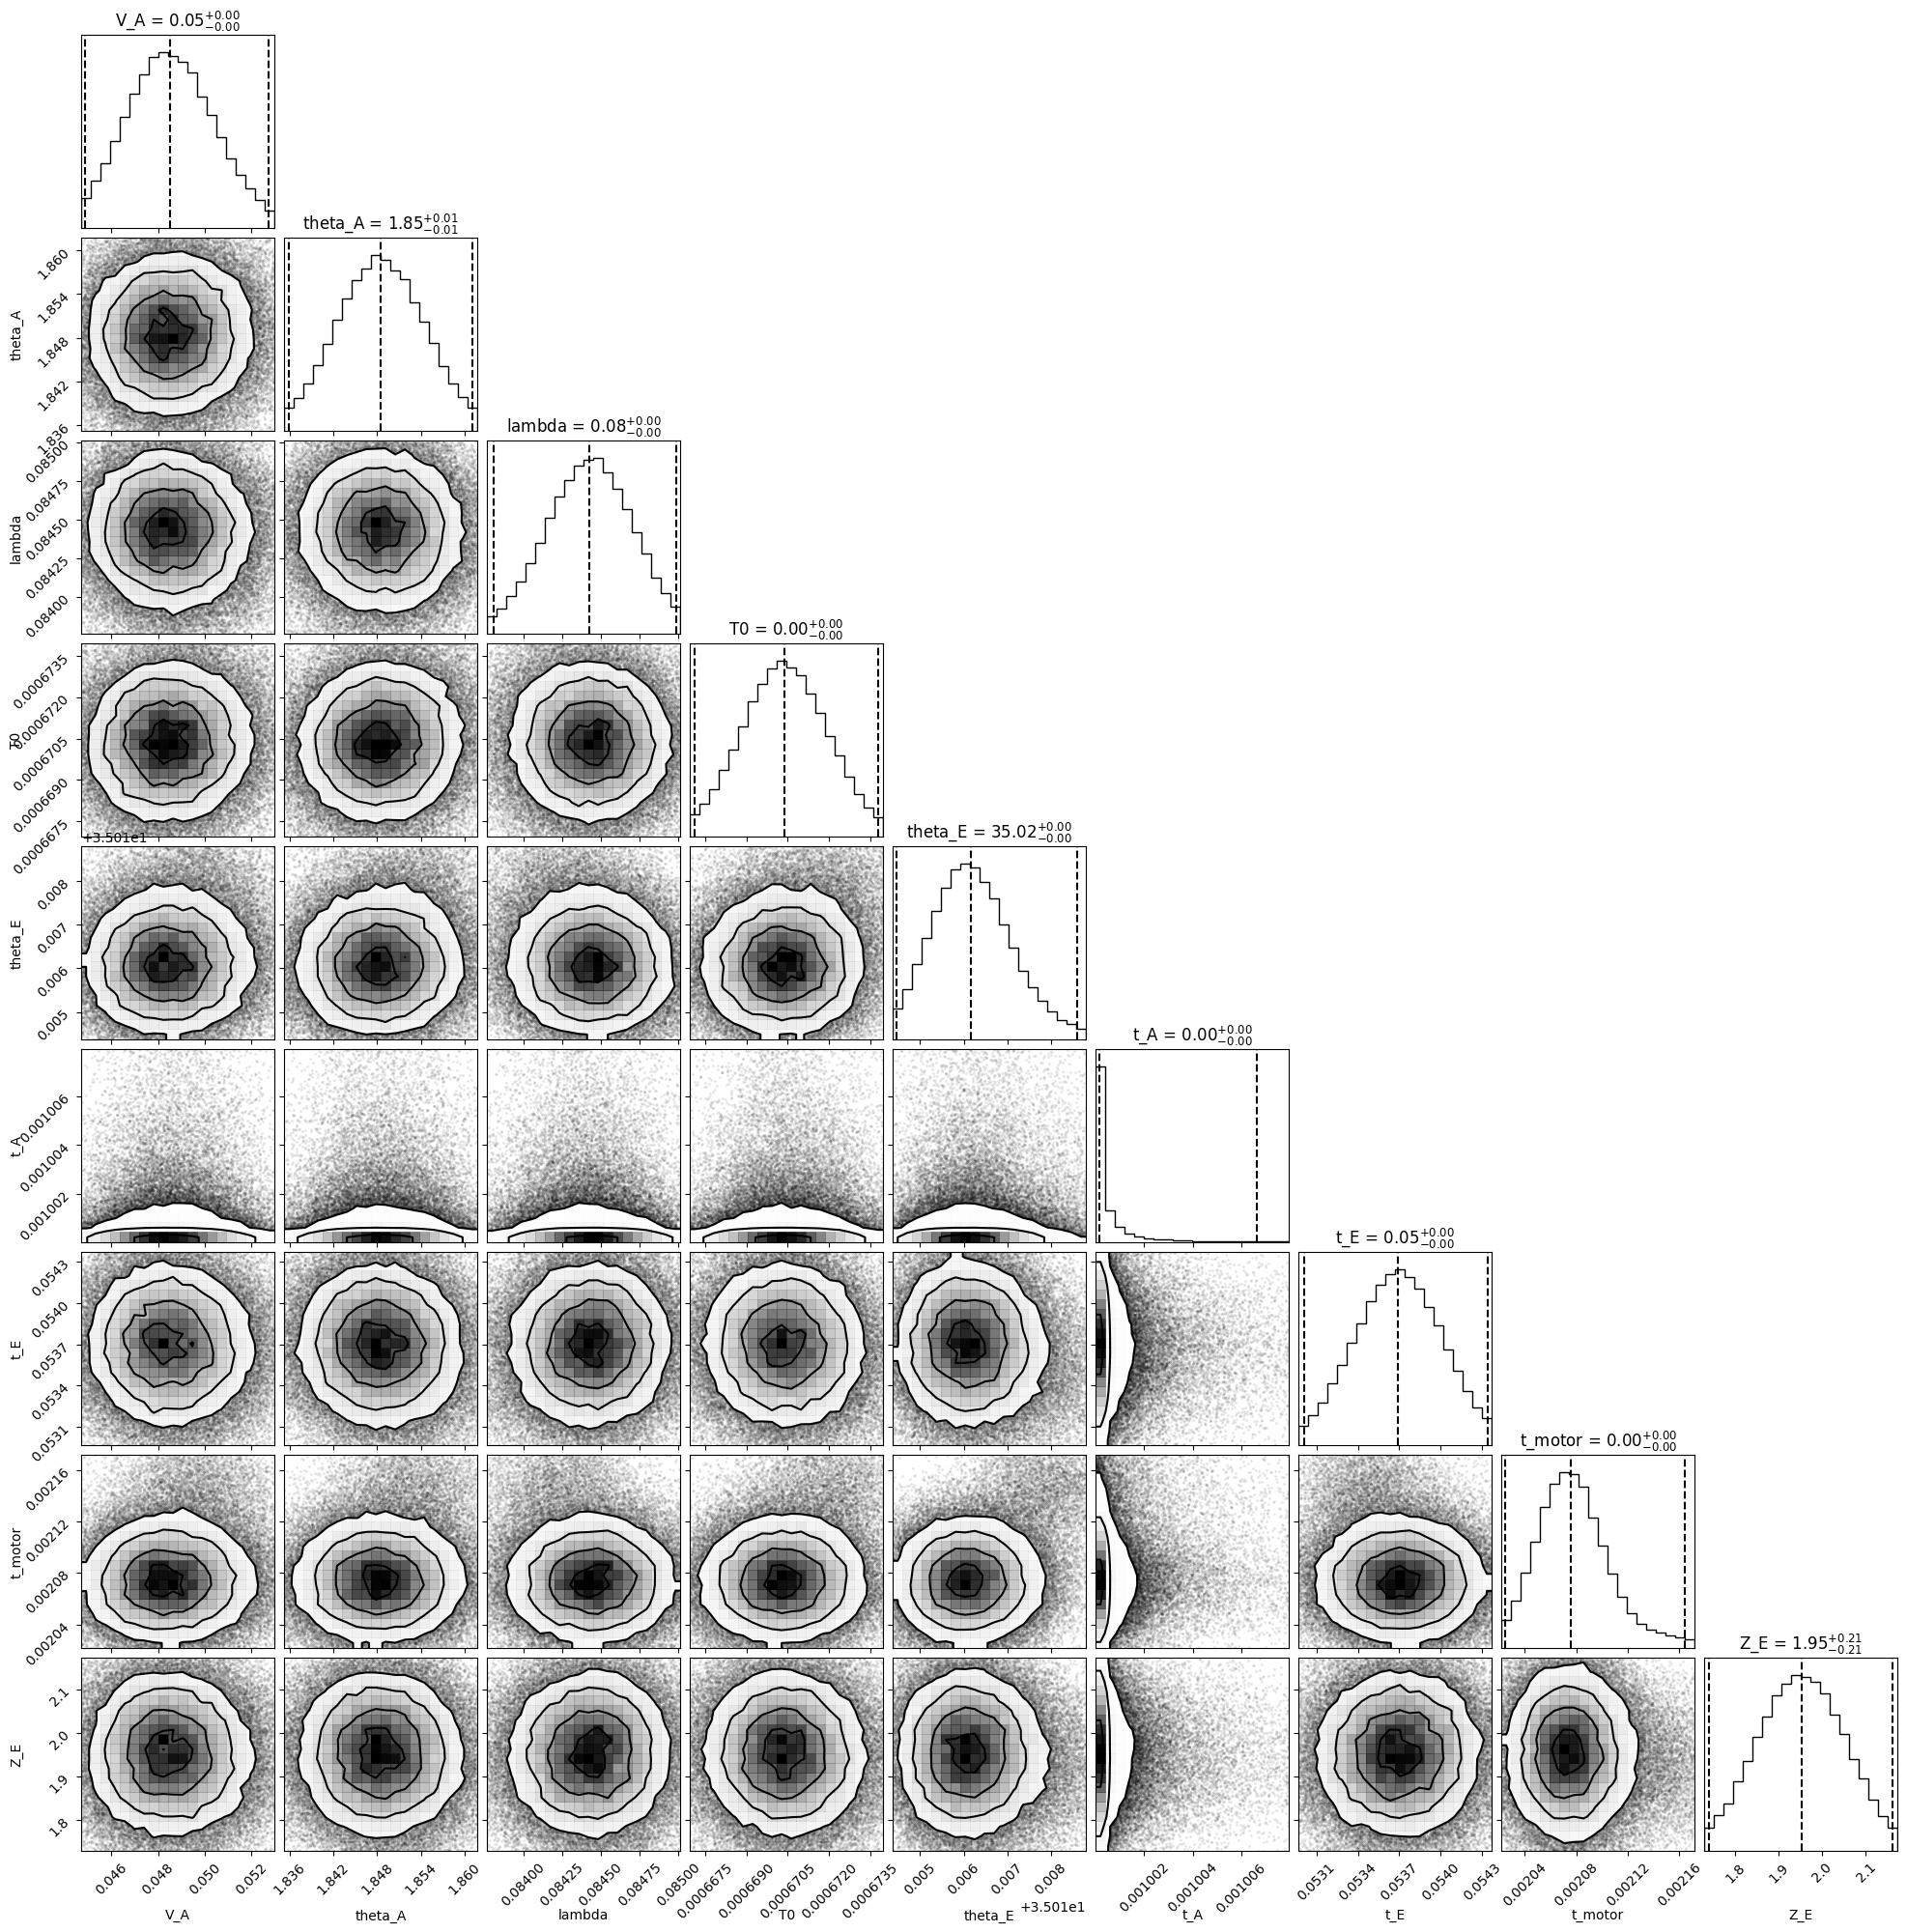

In [13]:
vp_samples = vp.sample(int(1e5))[0]

param_labels = ['V_A', 'theta_A', 'lambda', 'T0', 'theta_E', 't_A', 't_E', 't_motor', 'Z_E']

percentiles = np.percentile(vp_samples, [2, 98], axis=0)


_ranges = [(percentiles[0, i], percentiles[1, i]) for i in np.arange(vp_samples.shape[1])]


# Now create the corner plot using these ranges
corner.corner(
    vp_samples,
    labels=param_labels,
    show_titles=True,
    quantiles=[0.025, 0.5, 0.975],
    range=_ranges,
);

# Diagnostics

## psychometric curves

Data

In [14]:
num_RHS_dict = {}
num_trials_dict = {}
for ABL in ABL_arr:
    num_RHS_dict[ABL] = np.zeros_like(ILD_arr)
    num_trials_dict[ABL] = np.zeros_like(ILD_arr)

for idx, row in df_1.iterrows():
    ABL = row['ABL']
    ILD = row['ILD']
    if row['response_poke'] in [2,3]:
        num_trials_dict[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
        if row['response_poke'] == 3:
            num_RHS_dict[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1

Theory

In [15]:
# get mean of samples
mean_vb_params = {}
for i, label in enumerate(param_labels):
    mean_vb_params[label] = np.mean(vp_samples[:, i])

In [15]:
from psiam_tied_no_dv_map_utils import P_small_t_btn_x1_x2, CDF_E_minus_small_t_NORM_fn, rho_E_minus_small_t_NORM_fn, cum_A_t_fn
def up_RTs_fit_single_t_fn(t, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, K_max):
    """
    PDF of up RTs array
    """
    bound = 1

    P_A = rho_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A)
    P_EA_btn_1_2 = P_small_t_btn_x1_x2(1, 2, t-t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, K_max)
    t1 = t - t_motor - t_stim - t_E_aff
    t2 = t - t_stim
    P_E_plus_cum = CDF_E_minus_small_t_NORM_fn(t2, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, K_max) \
                - CDF_E_minus_small_t_NORM_fn(t1, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, K_max)


    P_E_plus = rho_E_minus_small_t_NORM_fn(t-t_E_aff-t_stim-t_motor, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, K_max)
    C_A = cum_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A)

    P_correct_unnorm = (P_A*(P_EA_btn_1_2 + P_E_plus_cum) + P_E_plus*(1-C_A))
    return P_correct_unnorm

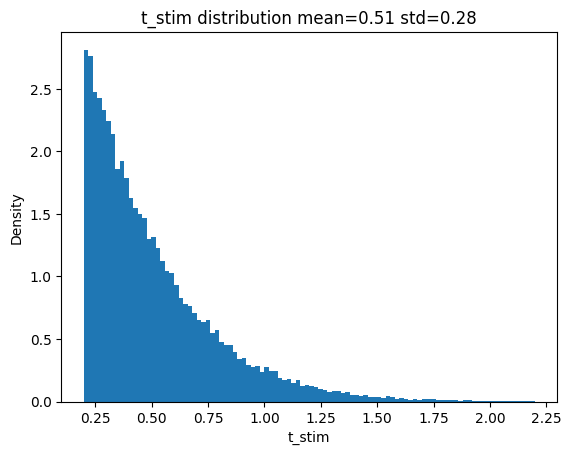

In [16]:
# get the t_stim distribution
t_stim_arr = []
for idx, row in df_1.iterrows():
    if row['response_poke'] in [2,3]:
        t_stim_arr.append(row['intended_fix'])


plt.hist(t_stim_arr, bins=100, density=True)    
plt.xlabel('t_stim')
plt.ylabel('Density')
plt.title(f't_stim distribution mean={np.mean(t_stim_arr):.2f} std={np.std(t_stim_arr):.2f}');

In [57]:
from scipy.integrate import quad
K_max = 10
t_stim = np.mean(t_stim_arr)

N_t_stim = 100

theory_psycho_dict = {}
for ABL in ABL_arr:
    theory_psycho_dict[ABL] = np.zeros_like(ILD_arr)

for ABL in ABL_arr:
    for idx, ILD in enumerate(ILD_arr):
        # Choose 100 random t_stim from real data
        random_t_stim_set = np.random.choice(t_stim_arr, N_t_stim)
        prob_up_set = np.zeros_like(random_t_stim_set)
        # Compute the probability of up for each random t_stim
        for i, random_t_stim in enumerate(random_t_stim_set):
            prob_up_set[i] = quad(up_RTs_fit_single_t_fn, 0.001, 20, args=(mean_vb_params['V_A'], mean_vb_params['theta_A'], \
                                                               ABL, ILD, mean_vb_params['lambda'], mean_vb_params['T0'], \
                                                                mean_vb_params['theta_E'], mean_vb_params['Z_E'], \
                                                               random_t_stim, mean_vb_params['t_A'], mean_vb_params['t_E'], \
                                                               mean_vb_params['t_motor'], K_max))[0]
        
        # average the 100 probabilities
        theory_psycho_dict[ABL][idx] = np.mean(prob_up_set)

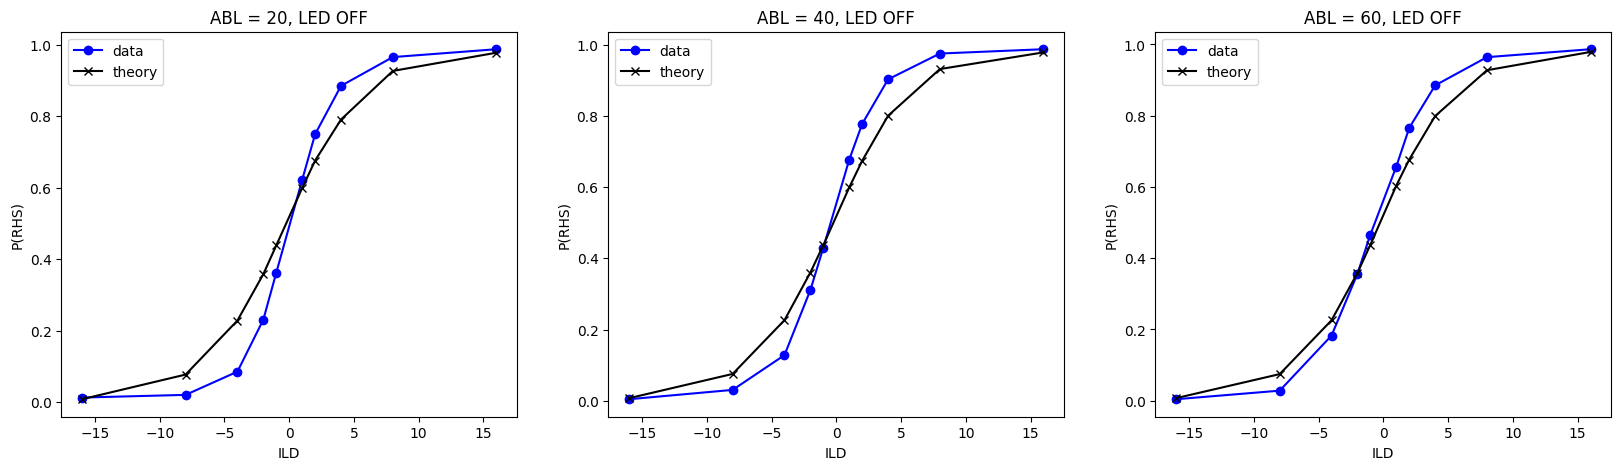

In [60]:
plt.figure(figsize=(20,5))
for i, ABL in enumerate(ABL_arr):
    plt.subplot(1, len(ABL_arr), i+1)
    plt.plot(ILD_arr, num_RHS_dict[ABL]/num_trials_dict[ABL], 'o-', label='data', color='b')
    plt.plot(ILD_arr, theory_psycho_dict[ABL], 'x-', label='theory', color='k')
    plt.title(f'ABL = {ABL}, LED OFF')
    plt.xlabel('ILD')
    plt.ylabel('P(RHS)')
    plt.legend();

## simulate data and compare

In [17]:
V_A = mean_vb_params['V_A']
theta_A = mean_vb_params['theta_A']

rate_lambda = mean_vb_params['lambda']
T_0 = mean_vb_params['T0']

theta_E = mean_vb_params['theta_E']
t_A_aff = mean_vb_params['t_A']
t_E_aff = mean_vb_params['t_E']
t_motor = mean_vb_params['t_motor']

Z_E = mean_vb_params['Z_E']


In [21]:
dt = 1e-4
N_sim = int(1000)
sim_results = Parallel(n_jobs=-1)(delayed(psiam_tied_data_gen_wrapper)(V_A, theta_A, ABL_arr, ILD_arr,\
                                                                        rate_lambda, T_0, theta_E, Z_E, \
                                                                            t_stim_arr, t_A_aff, t_E_aff, t_motor, dt)\
                                                                                  for _ in range(N_sim))